## learning-AI : HARTH classification (DL)
### The Human Activity Recognition Trondheim (HARTH)를 CNN 1D 방식의 classification (순환 데이터를 이용한 학습 : split_sequence())

<br>

- **임규연 (lky473736)**
- 2024.08.04., 2024.08.23. ~ 2024.09.01.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/779/harth
- **data abstract** : The Human Activity Recognition Trondheim (HARTH) dataset is a professionally-annotated dataset containing 22 subjects wearing two 3-axial accelerometers for around 2 hours in a free-living setting. The sensors were attached to the right thigh and lower back. The professional recordings and annotations provide a promising benchmark dataset for researchers to develop innovative machine learning approaches for precise HAR in free living.

------

## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 HARTH을 classification한다. **1D-CNN을 통하여 classification한다.**

저번 document에서 한 split_sequence()를 통한 순환 데이터 생성 및 1D-CNN에서의 validation set confusion matrix는 아래 figure에 첨부한다.

```txt
- validation data confusion matrix -

[[     0      0      0      0      0      0 191543      0      0      0
       0      0]
 [     0      0      0      0      0      0  46616      0      0      0
       0      0]
 [     0      0      0      0      0      0  40773      0      0      0
       0      0]
 [     0      0      0      0      0      0  12195      0      0      0
       0      0]
 [     0      0      0      0      0      0  10761      0      0      0
       0      0]
 [     0      0      0      0      0      0 118948      0      0      0
       0      0]
 [     0      0      0      0      0      0 464422      0      0      0
       0      0]
 [     0      0      0      0      0      0  68623      0      0      0
       0      0]
 [     0      0      0      0      0      0  63030      0      0      0
       0      0]
 [     0      0      0      0      0      0   8929      0      0      0
       0      0]
 [     0      0      0      0      0      0   6685      0      0      0
       0      0]
 [     0      0      0      0      0      0   1258      0      0      0
       0      0]]
```

**형편없는 accuracy를 보여준다.** 위와 같이 나온 까닭을 자세히 분석해보았다.

- `(원인 1) 잘못된 time step`
    - **앞으로는 EDA를 하기 전, uci dataset에 대한 설명을 먼저 정독한 후에 진행할 것.**
    - 'uci dataset archive : HARTH'에서 언급된 바에 따르면, 샘플링 속도는 50Hz라고 한다. 이는 1초 동안 50개의 데이터를 수집했다는 의미이다. -> **따라서 1초 간의 활동을 포착하려고 할 때 타임스텝은 50으로 설정해야 하는 것이 일반적이다.**
    - **타임스텝을 50으로 설정하고 학습한다.**
    
- `(원인 2) label counting의 불균형`
    - label '7' (앉기)의 target counting이 다른 label보다 압도적으로 커서 confusion matrix에서도 모든 predict label이 7에 편중되고 있는 경향성이 보인다.
    - **부족한 label에 해당되는 records의 수를 늘린다. (oversampling)**
    
- `(원인 3) 많은 양의 records`
    - 기존에는 harth dataset의 모든 파일을 병합하여 총 6461328개의 records가 담긴 dataframe을 다루어서 학습 시간이 지수적으로 증가하였다.
    - **이번 학습에서는 S006.csv만 다룬다.**
    

------


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

2024-09-03 18:51:10.859374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('../../data/harth/S006.csv')

df

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6
1,2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6
2,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6
3,2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6
4,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6
...,...,...,...,...,...,...,...,...
408704,2019-01-12 01:09:32.880,-0.690417,0.035710,-0.697054,0.228261,0.072950,0.985175,7
408705,2019-01-12 01:09:32.890,-0.745270,0.032438,-0.681320,-0.121986,0.063700,1.026665,7
408706,2019-01-12 01:09:32.900,-0.684827,0.037622,-0.703884,0.302960,0.076986,0.978313,7
408707,2019-01-12 01:09:32.910,-0.751518,0.028819,-0.668037,-0.241803,0.056675,1.026166,7


In [3]:
# timestamp 제거

df = df.drop('timestamp', axis = 1)
print (df.columns)

Index(['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label'], dtype='object')


In [4]:
# 결측치 확인 및 결측치를 각 열의 평균값으로 대체

print (df.isnull().sum())
df = df.fillna(df.mean())

print (df.isnull().sum())

back_x     0
back_y     0
back_z     0
thigh_x    0
thigh_y    0
thigh_z    0
label      0
dtype: int64
back_x     0
back_y     0
back_z     0
thigh_x    0
thigh_y    0
thigh_z    0
label      0
dtype: int64


label
7      253029
6       62682
13      25040
1       24889
8       13036
3       12693
130     11290
14       3130
5        1550
4        1370
Name: count, dtype: int64

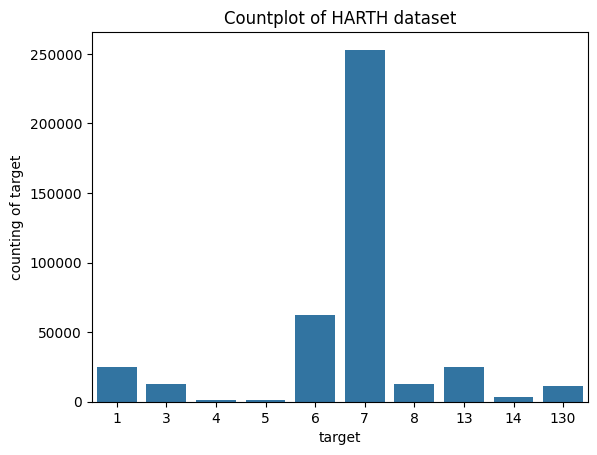

In [5]:
# target 별 counting

sns.countplot(data = df, x="label")
plt.xlabel('target')
plt.ylabel("counting of target")
plt.title('Countplot of HARTH dataset')

df['label'].value_counts()

In [6]:
# labelencoding을 통하여 각 label을 0-based 및 순서대로 구성

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

df['label'].value_counts()

label
5    253029
4     62682
7     25040
0     24889
6     13036
1     12693
9     11290
8      3130
3      1550
2      1370
Name: count, dtype: int64

In [7]:
'''
    oversampling은 함수로 구현한다. 원래는 SMOTE를 사용하려고 하였다.
    SMOTE (Synthetic Minority Over-sampling Technique)는 적은 수의 
    클래스 사이에서 새로운 가상 records를 구성하는 것이다.
    하지만, 랜덤으로 위치를 다시 uniting하기 때문에 시계열 데이터에는 적합하지 않아 직접 구현한다.
'''

# from imblearn.over_sampling import SMOTE

# smote = SMOTE()
# harth_input_resampled, harth_target_resampled = smote.fit_resample(harth_input, 
#                                                                    harth_target)
# print (harth_target_resampled.value_counts())
# print (harth_input_resampled.shape, harth_target_resampled.shape)

# class 별로 데이터 추출 -> 복제하는 방식
    
# 만약 30000개보다 샘플이 적음 -> replace == True로 복제
# 만약 30000개보다 샘플이 많음 -> 복제
    
def oversampling(df, target_col, max_size) :
    # 결과를 저장할 리스트 
    dfs = []
    
    for label in df[target_col].unique() :
        class_df = df[df[target_col] == label]
        
        if len(class_df) < max_size :
            # 샘플 수가 max_size보다 적으면 데이터를 복제하여 max_size로 만듦
            sampled_df = class_df.sample(max_size, replace=True, random_state=42)
        else :
            # 샘플 수가 max_size보다 많으면 앞부분부터 max_size만큼 선택함
            sampled_df = class_df.head(max_size)
        
        # 리스트에 추가
        dfs.append(sampled_df)
    
    # 리스트에 저장된 데이터프레임들을 합침
    df_resampled = pd.concat(dfs).reset_index(drop=True)
    
    return df_resampled

df_resampled = oversampling(df, 'label', max_size=30000)
print (df_resampled['label'].value_counts())

label
4    30000
0    30000
1    30000
5    30000
2    30000
3    30000
6    30000
9    30000
7    30000
8    30000
Name: count, dtype: int64


In [8]:
# split the input, target

harth_input = df.drop(columns=['label'])
harth_target = df['label']

print (harth_input.head())
print ('\n')
print (harth_target.head())

     back_x    back_y    back_z   thigh_x   thigh_y   thigh_z
0 -0.760242  0.299570  0.468570 -5.092732 -0.298644  0.709439
1 -0.530138  0.281880  0.319987  0.900547  0.286944  0.340309
2 -1.170922  0.186353 -0.167010 -0.035442 -0.078423 -0.515212
3 -0.648772  0.016579 -0.054284 -1.554248 -0.950978 -0.221140
4 -0.355071 -0.051831 -0.113419 -0.547471  0.140903 -0.653782


0    4
1    4
2    4
3    4
4    4
Name: label, dtype: int64


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(harth_input,
                                                    harth_target,
                                                    test_size = 0.2) 

X_train.shape, y_train.shape 

((326967, 6), (326967,))

In [10]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
    # find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [11]:
train_set = np.c_[X_train, y_train]
test_set = np.c_[X_test, y_test]

X_train, y_train = split_sequences(train_set, 50) # 50Hz -> 1초간의 활동을 포착하기 위해서 timestep을 50으로
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 50)
print(X_test.shape, y_test.shape)

(326918, 50, 6) (326918,)
(81693, 50, 6) (81693,)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 50, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 50, 32)         │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 25, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,386 (317.91 KB)

 Trainable params: 81,386 (317.91 KB)

 Non-trainable params: 0 (0.00 B)

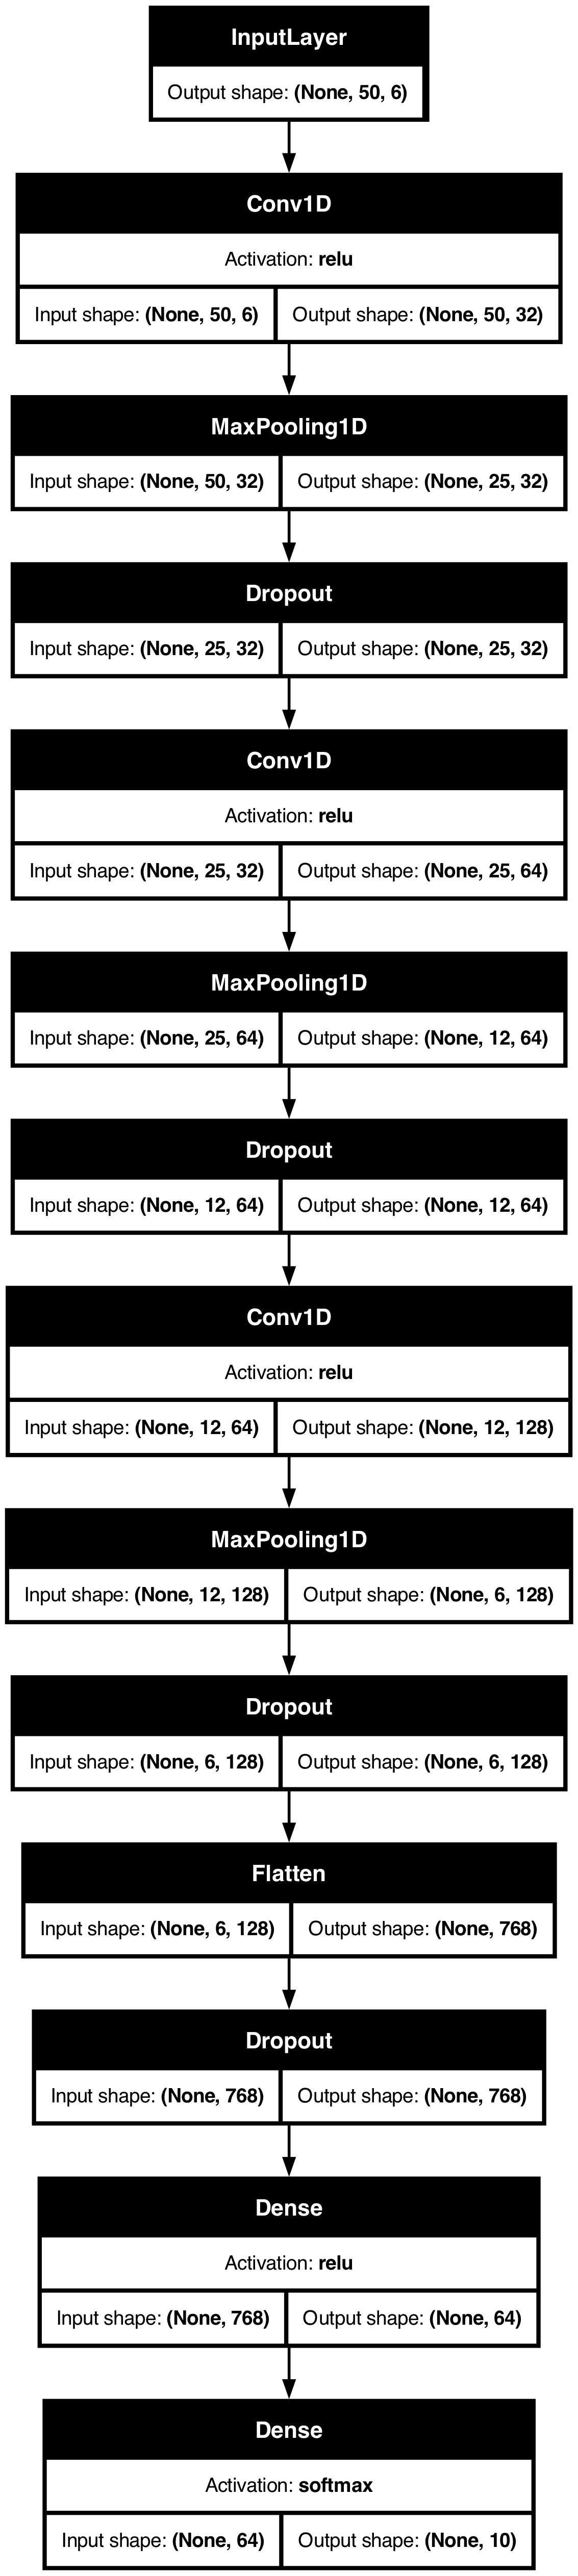

In [17]:
# modelling

# 모델 정의
input_layer = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))

# 첫 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_1 = keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
pooling_1 = keras.layers.MaxPooling1D(2)(conv_1)
dropout_1 = keras.layers.Dropout(0.3)(pooling_1)

# 두 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_2 = keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(dropout_1)
pooling_2 = keras.layers.MaxPooling1D(2)(conv_2)
dropout_2 = keras.layers.Dropout(0.3)(pooling_2)

# 세 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_3 = keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(dropout_2)
pooling_3 = keras.layers.MaxPooling1D(2)(conv_3)
dropout_3 = keras.layers.Dropout(0.3)(pooling_3)

# Flatten 레이어
flatten = keras.layers.Flatten()(dropout_3)

# Dropout 레이어
dropout_4 = keras.layers.Dropout(0.4)(flatten)

# Dense 레이어
dense_1 = keras.layers.Dense(64, activation='relu')(dropout_4)

# 출력 레이어
output_layer = keras.layers.Dense(len(set(y_train.tolist())), activation='softmax')(dense_1)

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [18]:
# compile

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile (optimizer=adam, 
               loss='sparse_categorical_crossentropy', 
               metrics=['accuracy'])

In [20]:
# fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                restore_best_weights=True)

from memory_profiler import profile

@profile # 메모리 오버플로우로 인한 시스템 다운을 막기 위해서
def train_model() :
    history = model.fit(X_train, y_train, epochs=100, 
                        validation_split=0.1, 
                        callbacks=early_stopping_cb, 
                        verbose=True)
    
    return history
    
history = train_model()
print (history)

ERROR: Could not find file /var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_24435/3543912406.py
Epoch 1/100
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 92s 10ms/step - accuracy: 0.7832 - loss: 0.6925 - val_accuracy: 0.8648 - val_loss: 0.3889
Epoch 2/100
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 92s 10ms/step - accuracy: 0.8636 - loss: 0.4016 - val_accuracy: 0.8839 - val_loss: 0.3318
Epoch 3/100
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 95s 10ms/step - accuracy: 0.8747 - loss: 0.3713 - val_accuracy: 0.8871 - val_loss: 0.3322
Epoch 4/100
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 98s 11ms/step - accuracy: 0.8786 - loss: 0.3591 - val_accuracy: 0.8884 - val_loss: 0.3127
Epoch 5/100
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 105s 11ms/step - accuracy: 0.8811 - loss: 0.3517 - val_accuracy: 0.8887 - val_loss: 0.3162
Epoch 6/100
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 110s 12ms/step - accuracy: 0.8818 - loss: 0.3461 - val_accuracy: 0.8906 - val_loss: 0.3073
Epoch 7/100
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 103s 11ms/step - accuracy: 0.8813 - loss: 0.3457 - 

{'accuracy': [0.8300116062164307, 0.8670613765716553, 0.876047670841217, 0.8793818354606628, 0.8800513744354248, 0.8810234069824219, 0.8821892142295837, 0.8832122087478638, 0.883606493473053, 0.8839429616928101, 0.8846566677093506, 0.8847314715385437, 0.8849557638168335, 0.8847756385803223, 0.8851392865180969, 0.8857952952384949, 0.8861045837402344, 0.885900616645813, 0.8864580392837524, 0.8865395784378052, 0.8866857290267944, 0.8863356709480286, 0.886502206325531], 'loss': [0.5174302458763123, 0.3923364579677582, 0.3668215274810791, 0.3564227223396301, 0.3523961305618286, 0.3481735587120056, 0.3443792164325714, 0.3415961265563965, 0.33945879340171814, 0.33889397978782654, 0.33629924058914185, 0.33588260412216187, 0.33541399240493774, 0.3345034420490265, 0.3334803879261017, 0.3331051766872406, 0.33119484782218933, 0.33073633909225464, 0.33049124479293823, 0.3298608958721161, 0.3288215696811676, 0.3294849097728729, 0.3293677270412445], 'val_accuracy': [0.8648293018341064, 0.883855402469

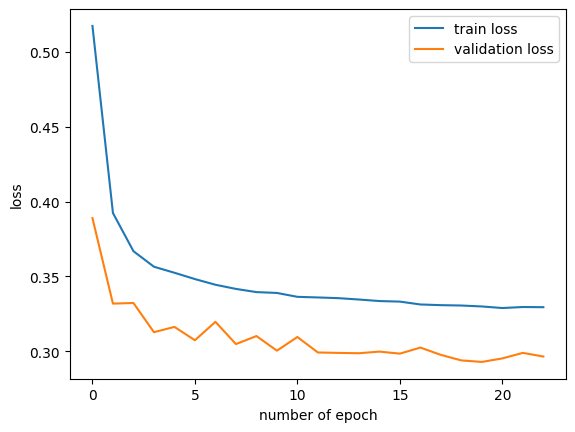

In [21]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

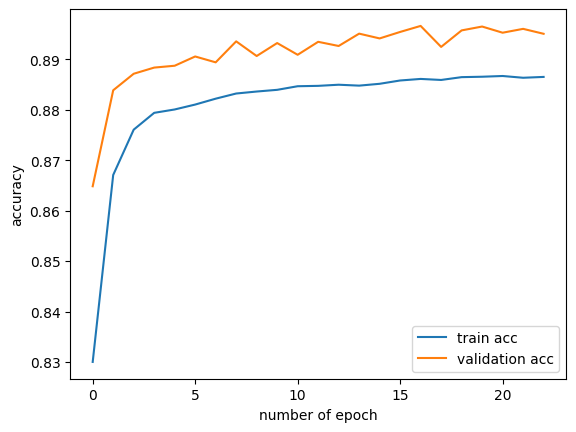

In [24]:
# acc 시각화

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('number of epoch')
plt.ylabel('accuracy')
plt.legend (['train acc', 'validation acc'])
plt.show() 

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

y_test_pred = model.predict(X_test)

y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_test = confusion_matrix(y_test, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_test = classification_report(y_test, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')

2553/2553 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
- test data confusion matrix -

[[ 3458    26     0     0  1041    22     1   251     0    85]
 [  900    52     0     0  1425     8     2    53     0    99]
 [  162     0     0     0    23     0     0    79     0    19]
 [  277     0     0     0    11     0     0    17     0     0]
 [  532    14     0     0 11635   182     7    41     0   114]
 [   16     0     0     0     2 50459     9    92     0    63]
 [    7     0     0     0     2     7  2518     8     0     1]
 [  284     0     0     0    43    73     2  3856     0   801]
 [   35     0     0     0    12     1     0   459    10   146]
 [   88     0     0     0    12    56     2   663     3  1427]]

 --------------- 

- test data report of classification -

              precision    recall  f1-score   support

         0.0       0.60      0.71      0.65      4884
         1.0       0.57      0.02      0.04      2539
         2.0       0.00      0.00      0.00       283
         3.0     

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  